# Import bibliotek

In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import *
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, KFold
from  sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
import optuna
import typing
import plotly.graph_objs as go
import itertools
import warnings
from scipy.special import digamma
from sklearn.neighbors import NearestNeighbors, KDTree
warnings.filterwarnings('ignore')
SEED = 17

# Ładowanie danych

In [2]:
data=pd.read_csv("../data/data_eda.csv")
data=data.drop(columns=['Unnamed: 0'])
features=data.columns.tolist()
features.remove('stars')
target='stars'
data

,pages,stars,reviews,series,mix,character,plot,funny,lighthearted,emotional,...,author_stars,Fiction,Nonfiction,Literary,Fantasy,Crime,Social,Children,Romans,Realism
0,273,4.00,2017,0,0.44,0.51,0.02,0.27,0.37,0.91,...,4.305000,1,1,0,0,0,1,0,1,1
1,302,3.78,7330,0,0.39,0.42,0.17,0.03,0.01,0.18,...,3.670000,1,0,0,0,1,0,0,0,0
2,400,4.15,16761,0,0.51,0.39,0.08,0.02,0.01,0.88,...,0.000000,1,0,1,0,0,0,0,0,0
3,459,4.16,2128,1,0.48,0.10,0.40,0.04,0.02,0.07,...,0.000000,1,0,0,1,0,0,0,0,0
4,160,3.65,6634,1,0.28,0.16,0.54,0.92,0.73,0.00,...,4.115000,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6925,432,4.15,30643,0,0.48,0.05,0.46,0.00,0.00,0.40,...,3.856667,1,0,0,1,1,0,0,0,0
6926,352,3.62,1058,0,0.55,0.13,0.30,0.15,0.10,0.25,...,3.700000,1,0,0,1,0,1,0,0,0
6927,535,3.88,30975,1,0.45,0.08,0.45,0.14,0.19,0.31,...,3.870000,1,0,0,1,0,0,1,0,0
6928,472,3.88,5914,1,0.64,0.12,0.22,0.07,0.00,0.36,...,3.660000,1,0,0,1,0,0,1,0,0


$\text{Podział danych na zbiór treningowy i testowy}$

In [3]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED)

In [4]:
def perform_cv(X: pd.DataFrame, y: pd.Series, algorithm: typing.Any, cv: typing.Any = KFold(n_splits=5, shuffle=True, random_state=SEED), metric: typing.Any = mean_squared_error) -> typing.List[float]:
    """
    Perform cross-validation and return list of scores
    
    Args:
        X (pd.DataFrame): input data
        y (pd.Series): target data
        algorithm (typing.Any): algorithm to use for training and prediction
        cv (typing.Any): cross-validation strategy
        metric (typing.Any): metric to use for evaluation
    
    Returns:
        typing.List[float]: list of scores in order: train_scores, validation_scores
    """
    train_scores = []
    validation_scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        algorithm.fit(X_train, y_train)
        y_train_pred = algorithm.predict(X_train)
        y_val_pred = algorithm.predict(X_val)
        train_scores.append(metric(y_train, y_train_pred, squared=False))
        validation_scores.append(metric(y_val, y_val_pred, squared=False))
    return np.mean(train_scores), np.mean(validation_scores)

def test_evaluation(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, algorithm: typing.Any, metric: typing.Any = mean_squared_error) -> float:
    """
    Train the algorithm on the train data and evaluate on the test data
    
    Args:
        X_train (pd.DataFrame): input train data
        y_train (pd.Series): target train data
        X_test (pd.DataFrame): input test data
        y_test (pd.Series): target test data
        algorithm (typing.Any): algorithm to use for training and prediction
        metric (typing.Any): metric to use for evaluation
    
    Returns:
        float: test score
    """
    algorithm.fit(X_train, y_train)
    y_test_pred = algorithm.predict(X_test)
    return metric(y_test, y_test_pred, squared=False)

## Base score

In [5]:
model = MLPRegressor(random_state=SEED)
train_scores, validation_scores = perform_cv(train_data[features], train_data[target], model)
print("Średni błąd RMSE na zbiorze treningowym: {:.5f}".format(train_scores))
print("Średni błąd RMSE na zbiorze walidacyjnym: {:.5f}".format(validation_scores))

Średni błąd RMSE na zbiorze treningowym: 2.16058
Średni błąd RMSE na zbiorze walidacyjnym: 2.06503


## Model z interakcjami

In [6]:
data_interactions=pd.read_csv("../data/data_interactions.csv")
data_interactions=data_interactions.drop(columns=['Unnamed: 0'])
features_interactions=data_interactions.columns.tolist()
features_interactions.remove('stars')
train_data_interactions, test_data_interactions = train_test_split(data_interactions, test_size=0.2, random_state=SEED)
model = MLPRegressor(random_state=SEED)
train_scores, validation_scores = perform_cv(train_data_interactions[features_interactions], train_data_interactions[target], model)
print("Średni błąd RMSE na zbiorze treningowym: {:.5f}".format(train_scores))
print("Średni błąd RMSE na zbiorze walidacyjnym: {:.5f}".format(validation_scores))

Średni błąd RMSE na zbiorze treningowym: 8010.13228
Średni błąd RMSE na zbiorze walidacyjnym: 7178.18110


## Model z transformacją zmiennych

In [7]:
data_transformations=pd.read_csv("../data/data_feature_engineering.csv")
data_transformations=data_transformations.drop(columns=['Unnamed: 0'])
features_transformations=data_transformations.columns.tolist()
features_transformations.remove('stars')
train_data_transformations, test_data_transformations = train_test_split(data_transformations, test_size=0.2, random_state=SEED)
model = MLPRegressor(random_state=SEED)
train_scores, validation_scores = perform_cv(train_data_transformations[features_transformations], train_data_transformations[target], model)
print("Średni błąd RMSE na zbiorze treningowym: {:.5f}".format(train_scores))
print("Średni błąd RMSE na zbiorze walidacyjnym: {:.5f}".format(validation_scores))

Średni błąd RMSE na zbiorze treningowym: 0.12664
Średni błąd RMSE na zbiorze walidacyjnym: 0.24091


$\text{Wyniki dla modelu bazowego oraz modelu wykorzystując dane z interakcjami wyglądają bardzo słabo w porównaniu do pozostałych algorytmów.}$<p>
$\text{Warto jednak zaznaczyć, że w przypadku sieci neuronowych, podobnie jak w KNN, należy znormalizować dane, ponieważ algorytmy te są wrażliwe na skalę danych.}$<p>
$\text{Z tego powodu, zdecydowanie najlepsze rezultaty uzyskano dla modelu z transformacją zmiennych, który zostanie wykorzystany do dalszej optymalizacji.}$

In [8]:
def perform_cv_scaling(X: pd.DataFrame, y: pd.Series, algorithm: typing.Any, cv: typing.Any = KFold(n_splits=5, shuffle=True, random_state=SEED), metric: typing.Any = mean_squared_error, scaler: typing.Any = StandardScaler(), features_to_scale: typing.List[str] = None, target_to_scale: bool = False) -> typing.List[float]:
    """
    Perform cross-validation and return list of scores
    
    Args:
        X (pd.DataFrame): input data
        y (pd.Series): target data
        algorithm (typing.Any): algorithm to use for training and prediction
        cv (typing.Any): cross-validation strategy
        metric (typing.Any): metric to use for evaluation
        scaler (typing.Any): scaler to use for scaling
        features_to_scale (typing.List[str]): list of features to scale
        target_to_scale (bool): whether to scale target data
    
    Returns:
        typing.List[float]: list of scores in order: train_scores, validation_scores
    """
    train_scores = []
    validation_scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
        X_val[features_to_scale] = scaler.transform(X_val[features_to_scale])
        if target_to_scale:
            y_train = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
            y_val = scaler.transform(y_val.values.reshape(-1, 1)).ravel()    
        algorithm.fit(X_train, y_train)
        y_train_pred = algorithm.predict(X_train)
        y_val_pred = algorithm.predict(X_val)
        if(target_to_scale):
            y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()
            y_val = scaler.inverse_transform(y_val.reshape(-1, 1)).ravel()
            y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1, 1)).ravel()
            y_val_pred = scaler.inverse_transform(y_val_pred.reshape(-1, 1)).ravel()
        train_scores.append(metric(y_train, y_train_pred, squared=False))
        validation_scores.append(metric(y_val, y_val_pred, squared=False))
    return np.mean(train_scores), np.mean(validation_scores)

def test_evaluation_scaling(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, algorithm: typing.Any, metric: typing.Any = mean_squared_error, scaler: typing.Any = StandardScaler(), features_to_scale: typing.List[str] = None, target_to_scale: bool = False) -> float:
    """
    Train the algorithm on the train data and evaluate on the test data
    
    Args:
        X_train (pd.DataFrame): input train data
        y_train (pd.Series): target train data
        X_test (pd.DataFrame): input test data
        y_test (pd.Series): target test data
        algorithm (typing.Any): algorithm to use for training and prediction
        metric (typing.Any): metric to use for evaluation.
        scaler (typing.Any): scaler to use for scaling
        features_to_scale (typing.List[str]): list of features to scale
        target_to_scale (bool): whether to scale target data
    
    Returns:
        float: test score
    """
    X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
    X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])
    if target_to_scale:
        y_train = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
        y_test = scaler.transform(y_test.values.reshape(-1, 1)).ravel()
    algorithm.fit(X_train, y_train)
    y_test_pred = algorithm.predict(X_test)
    if target_to_scale:
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
        y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).ravel()
    return metric(y_test, y_test_pred, squared=False)

$\text{Sieci neuronowe to algorytmy, które są wrażliwe na skalę danych.}$<p>
$\text{W sytuacji, gdy dane nie są znormalizowane, algorytm może mieć problem z odnalezieniem optymalnych wag.}$<p>
$\text{Dzieje się tak, ponieważ, gdy przemnażamy dane przez wagi, uzyskane macierze będą miały różne wartości, co może prowadzić do problemów z optymalizacją.}$<p>
$\text{Ponieważ przeprowadzone w pliku "2. Feature engineering" transformacje zmiennych nie posiadają jednolitej skali, przetestujemy czy w przypadku, gdy wykorzystamy kilka metod skalowania, wyniki się poprawią.}$

In [9]:
categorical_features = ['series', 'Fiction', 'Nonfiction', 'Literary', 'Fantasy','Crime', 'Social', 'Children', 'Romans', 'Realism']
continous_features = list(set(features_transformations) - set(categorical_features))
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler(), QuantileTransformer()]
scalers_names = ["StandardScaler", "MinMaxScaler", "RobustScaler", "QuantileTransformer"]
for scaler, scaler_name in zip(scalers, scalers_names):
    train_scores, validation_scores = perform_cv_scaling(train_data_transformations[features_transformations], train_data_transformations[target], model, scaler=scaler, features_to_scale=continous_features, target_to_scale=True)
    print("Średni błąd RMSE na zbiorze treningowym z użyciem skaler: {} wynosi: {:.5f}".format(scaler_name, train_scores))
    print("Średni błąd RMSE na zbiorze walidacyjnym z użyciem skaler: {} wynosi: {:.5f}".format(scaler_name, validation_scores))
    print()

Średni błąd RMSE na zbiorze treningowym z użyciem skaler: StandardScaler wynosi: 0.06585
Średni błąd RMSE na zbiorze walidacyjnym z użyciem skaler: StandardScaler wynosi: 0.22693

Średni błąd RMSE na zbiorze treningowym z użyciem skaler: MinMaxScaler wynosi: 0.14002
Średni błąd RMSE na zbiorze walidacyjnym z użyciem skaler: MinMaxScaler wynosi: 0.21470

Średni błąd RMSE na zbiorze treningowym z użyciem skaler: RobustScaler wynosi: 0.11173
Średni błąd RMSE na zbiorze walidacyjnym z użyciem skaler: RobustScaler wynosi: 0.24308

Średni błąd RMSE na zbiorze treningowym z użyciem skaler: QuantileTransformer wynosi: 0.16671
Średni błąd RMSE na zbiorze walidacyjnym z użyciem skaler: QuantileTransformer wynosi: 0.27252



$\text{Wyniki walidacji krzyżowej sugerują wykorzystanie narzędzia StandardScaler do transformacji zmiennych ciągłych (pomimo tego, że gorszy wynik na zbiorze walidacyjnym niż dla MinMax, to na zbiorze treningowym dużo lepszy).}$<p>
$\text{Zaletą RobustScaler jest zwiększona odporność na obserwacje odstające, co jest istotne w przypadku niektórych zmiennych ciągłych występujących w zbiorze danych (np.: author\_count, reviews, czy pages).}$<p>
$\text{Sprawdźmy wyniki na zbiorze testowym po dokonaniu standaryzacji.}$

In [10]:
model = MLPRegressor(random_state=SEED)
scaler = StandardScaler()
train_scores, validation_scores = perform_cv_scaling(train_data_transformations[features_transformations], train_data_transformations[target], model, scaler=scaler, features_to_scale=continous_features, target_to_scale=True)
print("Średni błąd RMSE na zbiorze treningowym: {:.5f}".format(train_scores))
print("Średni błąd RMSE na zbiorze walidacyjnym: {:.5f}".format(validation_scores))

Średni błąd RMSE na zbiorze treningowym: 0.06585
Średni błąd RMSE na zbiorze walidacyjnym: 0.22693


$\text{Podobnie jak w poprzednich przypadkach, ze względu na to, że zbiór danych zawiera bardzo dużą ilość zmiennych, zdecydowaliśmy się na zastosowanie Mutual Information w celu wyboru zmiennych, które mają największy wpływ na zmienną celu.}$

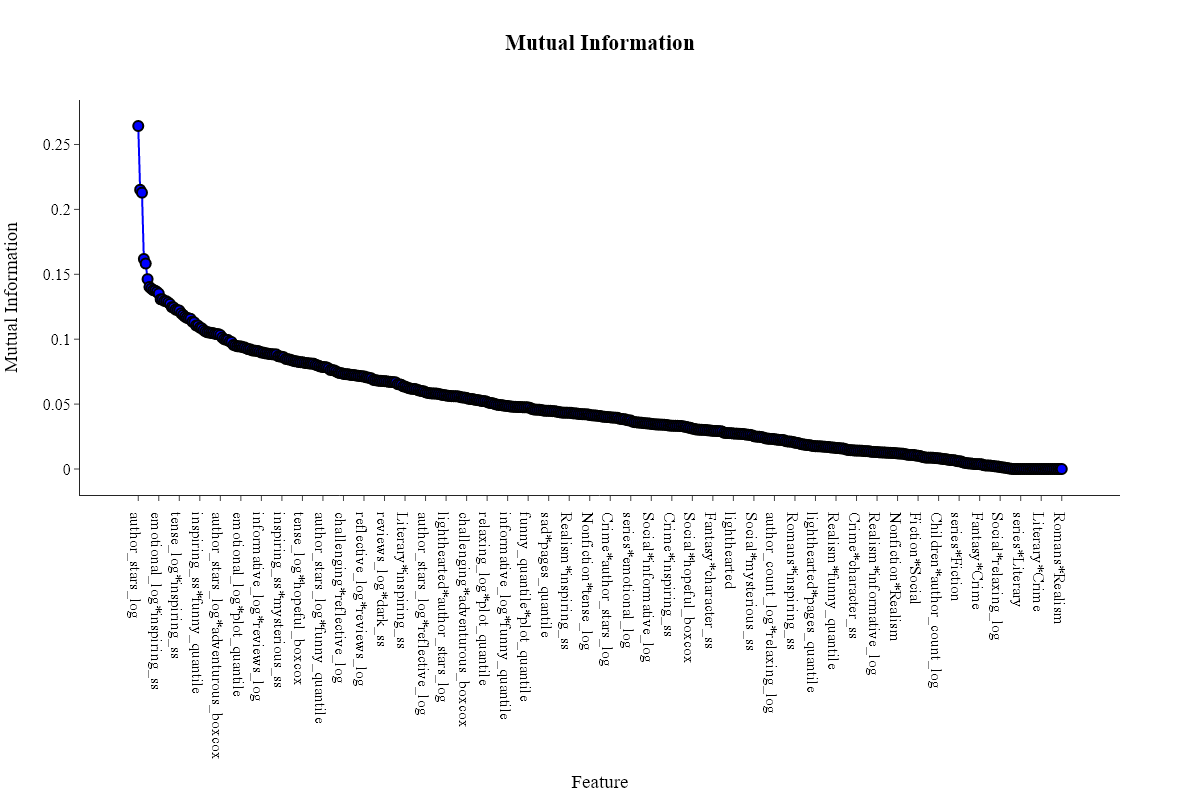

In [11]:
mi_scores = {feature: mutual_info_regression(train_data_transformations[[feature]], train_data_transformations[target], random_state=SEED)[0] for feature in features_transformations}
mi_scores = {k: v for k, v in sorted(mi_scores.items(), key=lambda item: item[1], reverse=True)}
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(mi_scores.keys()), y=list(mi_scores.values()), mode='lines+markers', marker=dict(size=10, color="blue", line=dict(width=2, color="black")), line=dict(width=2, color="blue")))
fig.update_layout(template="simple_white", width=1200, height=800, title="<b>Mutual Information<b>", title_x=0.5, xaxis_title="Feature", yaxis_title=f"Mutual Information", font=dict(family="Times New Roman",size=16,color="Black"), showlegend=False)
fig.show("png")

In [12]:
for quantile in [0, 0.1, 0.25, 0.5, 0.75, 0.9]:
    threshold = np.quantile(list(mi_scores.values()), quantile)
    features_to_drop = [k for k, v in mi_scores.items() if v < threshold]
    subset = set(features_transformations) - set(features_to_drop)
    features_to_scale = subset - set(categorical_features)
    model = MLPRegressor(random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data_transformations[list(subset)], train_data_transformations[target], model, scaler=scaler, features_to_scale=list(features_to_scale), target_to_scale=True)
    print("Kwantyl: {}; Procent zmiennych: {}%".format(1-quantile, np.round(len(subset)/len(features_transformations)*100, 2)))
    print(f"Średni błąd RMSE na zbiorze treningowym dla kwantyla {quantile}: {train_scores}")
    print(f"Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla {quantile}: {validation_scores}")
    print()

Kwantyl: 1; Procent zmiennych: 100.0%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0: 0.06460493354174823
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0: 0.22710887934287305

Kwantyl: 0.9; Procent zmiennych: 89.92%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.1: 0.060005759436613
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.1: 0.22638155498542703

Kwantyl: 0.75; Procent zmiennych: 75.0%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.25: 0.06353556771642332
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.25: 0.23021443480456477

Kwantyl: 0.5; Procent zmiennych: 50.0%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.5: 0.06649011889841674
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.5: 0.22553092048234863

Kwantyl: 0.25; Procent zmiennych: 25.0%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.75: 0.11106637960608812
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.75: 0.21983351198643825

Kwantyl: 0.0999

$\text{Zmniejszenie liczby zmiennych do zaledwie 10\% wszystkich cech, pozwoliło zmniejszyć stratę dla zbioru walidacyjnego.}$<p>
$\text{Oczywiście widoczne jest również znaczne pogorszenie rezultatów dla zbioru treningowego, jednak wciąż są one na zadowalającym poziomie.}$<p>
$\text{Zbadamy dokładniej okolice kwantyla 0.9, w celu znalezienia optymalnej liczby zmiennych.}$

In [13]:
for quantile in np.linspace(0.8, 0.95, 16):
    threshold = np.quantile(list(mi_scores.values()), quantile)
    features_to_drop = [k for k, v in mi_scores.items() if v < threshold]
    subset = set(features_transformations) - set(features_to_drop)
    features_to_scale = subset - set(categorical_features)
    model = MLPRegressor(random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data_transformations[list(subset)], train_data_transformations[target], model, scaler=scaler, features_to_scale=list(features_to_scale), target_to_scale=True)
    print("Kwantyl: {}; Procent zmiennych: {}%".format(1-quantile, np.round(len(subset)/len(features_transformations)*100, 2)))
    print(f"Średni błąd RMSE na zbiorze treningowym dla kwantyla {quantile}: {train_scores}")
    print(f"Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla {quantile}: {validation_scores}")
    print()

Kwantyl: 0.19999999999999996; Procent zmiennych: 20.16%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.8: 0.11872934320167103
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.8: 0.220294093129029

Kwantyl: 0.18999999999999995; Procent zmiennych: 19.15%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.81: 0.11908814978461198
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.81: 0.2194640922653254

Kwantyl: 0.17999999999999994; Procent zmiennych: 18.15%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.8200000000000001: 0.12326445242268672
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.8200000000000001: 0.21965968725451607

Kwantyl: 0.16999999999999993; Procent zmiennych: 17.14%
Średni błąd RMSE na zbiorze treningowym dla kwantyla 0.8300000000000001: 0.13233450848652023
Średni błąd RMSE na zbiorze walidacyjnym dla kwantyla 0.8300000000000001: 0.22162906455634937

Kwantyl: 0.16000000000000003; Procent zmiennych: 16.13%
Średni błąd RMSE na zbiorze t

$\text{Bazując na otrzymanych wynikach, zdecydowaliśmy się na wybór kwantyla 0.87 jako progu odcięcia.}$

In [14]:
quantile = 0.87
threshold = np.quantile(list(mi_scores.values()), quantile)
features_to_drop = [k for k, v in mi_scores.items() if v < threshold]
subset = list(set(features_transformations) - set(features_to_drop))
features_to_scale = list(set(subset) - set(categorical_features))
model = MLPRegressor(random_state=SEED)
train_scores, validation_scores = perform_cv_scaling(train_data_transformations[subset], train_data_transformations[target], model, scaler=scaler, features_to_scale=features_to_scale, target_to_scale=True)
print("Procent zmiennych: {}%".format(np.round(len(subset)/len(features_transformations)*100, 2)))
print(f"Średni błąd RMSE na zbiorze treningowym: {train_scores}")
print(f"Średni błąd RMSE na zbiorze walidacyjnym: {validation_scores}")
print()

Procent zmiennych: 13.1%
Średni błąd RMSE na zbiorze treningowym: 0.14296114792798603
Średni błąd RMSE na zbiorze walidacyjnym: 0.2198081629682324



$\text{Wyniki uległy znacznej poprawie względem modelu bazowego, natomiast warto odnotować, że sieć została przetrenowana.}$<p>
$\text{W kolejnych etapach będziemy starali się dokonać pewnej regularyzacji w celu możliwego zredukoania overfittingu.}$

# Optymalizacja

## hidden_layer_sizes

$\text{W przypadku sieci neuronowych, jednym z najważniejszych parametrów jest liczba warstw ukrytych oraz liczba neuronów w każdej z warstw.}$<p>
$\text{Zbyt mała liczba neuronów może prowadzić do underfittingu, natomiast zbyt duża do overfittingu oraz długiego czasu uczenia.}$<p>
$\text{Oczywiście dokładne znalezienie optymalnego rozwiązania jest niemal niemożliwe, dlatego spróbujemy zaledwie z kilkoma różnymi wartościami tego parametru.}$

In [15]:
hidden_layer_sizes = [50,100,150] + list(itertools.permutations([50,100,150],2)) + list(itertools.permutations([50,100,150],3))
for hidden_layer_size in hidden_layer_sizes:
    model = MLPRegressor(hidden_layer_sizes=hidden_layer_size, random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data_transformations[subset], train_data_transformations[target], model, scaler=scaler, features_to_scale=features_to_scale, target_to_scale=True)
    print("Hidden layer sizes: {}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(hidden_layer_size, train_scores, validation_scores))

Hidden layer sizes: 50; RMSE train: 0.16443; RMSE validation: 0.21818
Hidden layer sizes: 100; RMSE train: 0.14296; RMSE validation: 0.21981
Hidden layer sizes: 150; RMSE train: 0.13145; RMSE validation: 0.21762
Hidden layer sizes: (50, 100); RMSE train: 0.10584; RMSE validation: 0.23920
Hidden layer sizes: (50, 150); RMSE train: 0.09557; RMSE validation: 0.24500
Hidden layer sizes: (100, 50); RMSE train: 0.09266; RMSE validation: 0.24299
Hidden layer sizes: (100, 150); RMSE train: 0.06790; RMSE validation: 0.24701
Hidden layer sizes: (150, 50); RMSE train: 0.07845; RMSE validation: 0.24370
Hidden layer sizes: (150, 100); RMSE train: 0.06902; RMSE validation: 0.23619
Hidden layer sizes: (50, 100, 150); RMSE train: 0.05197; RMSE validation: 0.25591
Hidden layer sizes: (50, 150, 100); RMSE train: 0.05386; RMSE validation: 0.25621
Hidden layer sizes: (100, 50, 150); RMSE train: 0.05784; RMSE validation: 0.25777
Hidden layer sizes: (100, 150, 50); RMSE train: 0.04595; RMSE validation: 0.24

$\text{Widzimy, że wraz ze zwiększaniem liczby neuronów oraz warstw, wyniki na zbiorze trenigowym ulegają poprawie.}$<p>
$\text{Niestety, powoduje to również zwiększenie overfittingu.}$<p>
$\text{Wygląda na to, że optymalna będzie zaledwie jedna warstwa w sieci.}$<p>
$\text{Na dalszym etapie, podczas tuningowania całej sieci, testować będziemy wyniki dla wartości w okolicach 100 neuronów w pojedynczej warstwie.}$

## activation

$\text{Kolejnym ważnym parametrem jest funkcja aktywacji.}$<p>
$\text{Odpowiada ona za to, jaka transformacja zostanie zastosowana na danych wychodzących z warstwy ukrytej.}$<p>
$\text{Dla sieci neuronowych dostępne są różne funkcje aktywacji, poniżej przetestujemy następujące: identity, logistic, tanh, relu.}$

In [16]:
activations = ['identity', 'logistic', 'tanh', 'relu']
for activation in activations:
    model = MLPRegressor(hidden_layer_sizes=100, activation=activation, random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data_transformations[subset], train_data_transformations[target], model, scaler=scaler, features_to_scale=features_to_scale, target_to_scale=True)
    print("Activation: {}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(activation, train_scores, validation_scores))

Activation: identity; RMSE train: 0.22673; RMSE validation: 0.22973
Activation: logistic; RMSE train: 0.19952; RMSE validation: 0.21925
Activation: tanh; RMSE train: 0.14934; RMSE validation: 0.22678
Activation: relu; RMSE train: 0.14296; RMSE validation: 0.21981


$\text{Najlepsze wyniki na zbiorze walidacyjnym uzyskano w przypadku funkcji aktywacji relu.}$

## solver

$\text{Parametr solver odpowiada za algorytm optymalizacji wag - za to jak będą one aktualizowane w trakcie uczenia.}$<p>
$\text{Podobnie jak w przypadku funkcji aktywacji, dostępne są różne algorytmy, poniżej przetestujemy następujące: lbfgs, sgd, adam.}$

In [17]:
solvers = ['lbfgs', 'sgd', 'adam']
for solver in solvers:
    model = MLPRegressor(hidden_layer_sizes=100, activation='relu', solver=solver, random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data_transformations[subset], train_data_transformations[target], model, scaler=scaler, features_to_scale=features_to_scale, target_to_scale=True)
    print("Solver: {}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(solver, train_scores, validation_scores))

Solver: lbfgs; RMSE train: 0.13316; RMSE validation: 0.23270
Solver: sgd; RMSE train: 0.20084; RMSE validation: 0.21918
Solver: adam; RMSE train: 0.14296; RMSE validation: 0.21981


$\text{Zarówno rezultaty na zbiorze treningowym, jak i walidacyjnym są najlepsze dla solvera adam.}$

## alpha

$\text{Parametr alpha odpowiada za regularyzację sieci.}$<p>
$\text{alpha służy do ograniczenia rozmiaru wag, co może pomóc w redukcji overfittingu.}$

In [18]:
alphas = [10**i for i in range(-5, 5)]
for alpha in alphas:
    model = MLPRegressor(hidden_layer_sizes=100, activation='relu', solver='adam', alpha=alpha, random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data_transformations[subset], train_data_transformations[target], model, scaler=scaler, features_to_scale=features_to_scale, target_to_scale=True)
    print("Alpha: {}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(alpha, train_scores, validation_scores))

Alpha: 1e-05; RMSE train: 0.14260; RMSE validation: 0.21931
Alpha: 0.0001; RMSE train: 0.14296; RMSE validation: 0.21981
Alpha: 0.001; RMSE train: 0.14310; RMSE validation: 0.21993
Alpha: 0.01; RMSE train: 0.14329; RMSE validation: 0.21959
Alpha: 0.1; RMSE train: 0.14826; RMSE validation: 0.21659
Alpha: 1; RMSE train: 0.18091; RMSE validation: 0.21065
Alpha: 10; RMSE train: 0.22870; RMSE validation: 0.23151
Alpha: 100; RMSE train: 0.25618; RMSE validation: 0.25658
Alpha: 1000; RMSE train: 0.30130; RMSE validation: 0.30145
Alpha: 10000; RMSE train: 0.30130; RMSE validation: 0.30144


$\text{Wraz ze wzrostem wartości parametru alpha, wyniki na zbiorze trenigowym ulegają pogorszeniu.}$<p>
$\text{W przypadku zbioru walidacyjnego, najlepsze wyniki uzyskano dla wartości 1.}$<p>
$\text{Możemy dokładniej zbadać okolice wartości 1.}$

In [19]:
alphas = np.linspace(0.5, 2, 16)
for alpha in alphas:
    model = MLPRegressor(hidden_layer_sizes=100, activation='relu', solver='adam', alpha=alpha, random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data_transformations[subset], train_data_transformations[target], model, scaler=scaler, features_to_scale=features_to_scale, target_to_scale=True)
    print("Alpha: {}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(alpha, train_scores, validation_scores))

Alpha: 0.5; RMSE train: 0.16672; RMSE validation: 0.21010
Alpha: 0.6; RMSE train: 0.17092; RMSE validation: 0.21028
Alpha: 0.7; RMSE train: 0.17346; RMSE validation: 0.20957
Alpha: 0.8; RMSE train: 0.17698; RMSE validation: 0.20966
Alpha: 0.9; RMSE train: 0.18038; RMSE validation: 0.21066
Alpha: 1.0; RMSE train: 0.18091; RMSE validation: 0.21065
Alpha: 1.1; RMSE train: 0.18427; RMSE validation: 0.21020
Alpha: 1.2000000000000002; RMSE train: 0.18633; RMSE validation: 0.21083
Alpha: 1.3; RMSE train: 0.18887; RMSE validation: 0.21183
Alpha: 1.4; RMSE train: 0.19022; RMSE validation: 0.21195
Alpha: 1.5; RMSE train: 0.19219; RMSE validation: 0.21267
Alpha: 1.6; RMSE train: 0.19419; RMSE validation: 0.21245
Alpha: 1.7000000000000002; RMSE train: 0.19532; RMSE validation: 0.21301
Alpha: 1.8; RMSE train: 0.19712; RMSE validation: 0.21387
Alpha: 1.9000000000000001; RMSE train: 0.19903; RMSE validation: 0.21429
Alpha: 2.0; RMSE train: 0.20027; RMSE validation: 0.21497


$\text{Najlepszy rezultat na zbiorze walidacyjnym, dla alpha=0.9.}$

## learning_rate

$\text{Parametr learning\_rate odpowiada za to jak silnie aktualizowane są wagi w trakcie uczenia.}$

In [20]:
learning_rates = [10**i for i in range(-5, 1)]
for learning_rate in learning_rates:
    model = MLPRegressor(hidden_layer_sizes=100, activation='relu', solver='adam', alpha=0.9, learning_rate_init=learning_rate, random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data_transformations[subset], train_data_transformations[target], model, scaler=scaler, features_to_scale=features_to_scale, target_to_scale=True)
    print("Learning rate: {}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(learning_rate, train_scores, validation_scores))

Learning rate: 1e-05; RMSE train: 0.22974; RMSE validation: 0.23437
Learning rate: 0.0001; RMSE train: 0.20198; RMSE validation: 0.21822
Learning rate: 0.001; RMSE train: 0.18038; RMSE validation: 0.21066
Learning rate: 0.01; RMSE train: 0.21011; RMSE validation: 0.22223
Learning rate: 0.1; RMSE train: 0.22535; RMSE validation: 0.22908
Learning rate: 1; RMSE train: 0.23017; RMSE validation: 0.23622


$\text{Dla wartości domyślnej: 0.001, wyniki na zbiorze walidacyjnym są najlepsze.}$

## max_iter

$\text{Parametr max\_iter odpowiada za maksymalną liczbę iteracji - czyli ile razy algorytm będzie uczył się na danych i optymalizował wagi.}$

In [21]:
max_iters = [i for i in range(100, 1001, 100)]
for max_iter in max_iters:
    model = MLPRegressor(hidden_layer_sizes=100, activation='relu', solver='adam', alpha=0.9, learning_rate_init=0.001, max_iter=max_iter, random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data_transformations[subset], train_data_transformations[target], model, scaler=scaler, features_to_scale=features_to_scale, target_to_scale=True)
    print("Max iter: {}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(max_iter, train_scores, validation_scores))

Max iter: 100; RMSE train: 0.18605; RMSE validation: 0.21272
Max iter: 200; RMSE train: 0.18038; RMSE validation: 0.21066
Max iter: 300; RMSE train: 0.18038; RMSE validation: 0.21066
Max iter: 400; RMSE train: 0.18038; RMSE validation: 0.21066
Max iter: 500; RMSE train: 0.18038; RMSE validation: 0.21066
Max iter: 600; RMSE train: 0.18038; RMSE validation: 0.21066
Max iter: 700; RMSE train: 0.18038; RMSE validation: 0.21066
Max iter: 800; RMSE train: 0.18038; RMSE validation: 0.21066
Max iter: 900; RMSE train: 0.18038; RMSE validation: 0.21066
Max iter: 1000; RMSE train: 0.18038; RMSE validation: 0.21066


$\text{Od okolic 300 iteracji, brak wpływu liczby iteracji na wyniki modelu.}$<p>
$\text{Warto zaznaczyć, że przy 200 iteracjach model osiąga najniższą wartość straty na zbiorze walidacyjnym.}$<p>
$\text{Spróbujemy zatem znaleźć dokładniejszą wartość.}$

In [22]:
max_iters = [i for i in range(100, 300, 20)]
for max_iter in max_iters:
    model = MLPRegressor(hidden_layer_sizes=100, activation='relu', solver='adam', alpha=0.9, learning_rate_init=0.001, max_iter=max_iter, random_state=SEED)
    train_scores, validation_scores = perform_cv_scaling(train_data_transformations[subset], train_data_transformations[target], model, scaler=scaler, features_to_scale=features_to_scale, target_to_scale=True)
    print("Max iter: {}; RMSE train: {:.5f}; RMSE validation: {:.5f}".format(max_iter, train_scores, validation_scores))

Max iter: 100; RMSE train: 0.18605; RMSE validation: 0.21272
Max iter: 120; RMSE train: 0.18461; RMSE validation: 0.21203
Max iter: 140; RMSE train: 0.18145; RMSE validation: 0.21100
Max iter: 160; RMSE train: 0.17931; RMSE validation: 0.20975
Max iter: 180; RMSE train: 0.18038; RMSE validation: 0.21066
Max iter: 200; RMSE train: 0.18038; RMSE validation: 0.21066
Max iter: 220; RMSE train: 0.18038; RMSE validation: 0.21066
Max iter: 240; RMSE train: 0.18038; RMSE validation: 0.21066
Max iter: 260; RMSE train: 0.18038; RMSE validation: 0.21066
Max iter: 280; RMSE train: 0.18038; RMSE validation: 0.21066


$\text{Najlepszy wynik dla max\_iter=160.}$

# Tuning

In [23]:
class RandomSearchCV:
    """
    This class is used to optimize the hyperparameters of the algorithm using Random Search.
    """

    def __init__(
        self,
        algorithm: typing.Any,
        metric: str,
        cv: typing.Any = KFold(n_splits=5, shuffle=True, random_state=17),
        n_trials: int = 100,
        seed: int = 17,
    ) -> None:
        """
        Initializes the RandomSearchCV class.

        Args:
            algorithm (typing.Any): algorithm to optimize.
            metric (str): metric to use for optimization.
            cv (typing.Any): cross-validation strategy.
            n_trials (int): number of trials to perform.
            seed (int): random seed.
        """
        self.algorithm = algorithm
        metrics = {
            "accuracy": [lambda y, y_pred: accuracy_score(y, y_pred), "preds", "maximize"],
            "roc_auc": [lambda y, y_pred: roc_auc_score(y, y_pred), "probs", "maximize"],
            "mse": [lambda y, y_pred: mean_squared_error(y, y_pred), "preds", "minimize"],
            "rmse": [
                lambda y, y_pred: mean_squared_error(y, y_pred, squared=False),
                "preds", "minimize"
            ],
            "mae": [lambda y, y_pred: mean_absolute_error(y, y_pred), "preds", "minimize"],
        }
        if metric not in metrics:
            raise ValueError("Unsupported metric: {}".format(metric))
        self.eval_metric = metrics[metric][0]
        self.metric_type = metrics[metric][1]
        self.direction = metrics[metric][2]
        self.cv = cv
        self.n_trials = n_trials
        self.seed = seed
    
    def check_X(
        self, X: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if X is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            X: (Union[pd.DataFrame, pd.Series, np.ndarray]): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        if (
            not isinstance(X, pd.DataFrame)
            and not isinstance(X, pd.Series)
            and not isinstance(X, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of X. It should be pandas DataFrame, pandas Series, numpy array."
            )
        X = np.array(X)
        if X.ndim == 1:
            X = X[None, :]
        return X

    def check_y(
        self, y: typing.Union[pd.DataFrame, pd.Series, np.ndarray]
    ) -> np.ndarray:
        """Check if y is pandas DataFrame, pandas Series or numpy array and convert it to numpy array.

        Args:
            y: (Union[pd.DataFrame, pd.Series, np.ndarray]): target data.

        Returns:
            y: (np.ndarray): converted target data.
        """
        if (
            not isinstance(y, pd.DataFrame)
            and not isinstance(y, pd.Series)
            and not isinstance(y, np.ndarray)
        ):
            raise TypeError(
                "Wrong type of y. It should be pandas DataFrame, pandas Series, numpy array."
            )
        y = np.array(y)
        if y.ndim != 1:
            y = y.squeeze()
        return y

    def check_for_object_columns(self, X: np.ndarray) -> np.ndarray:
        """Check if X contains object columns and convert it to numeric data.

        Args:
            X: (np.ndarray): input data.

        Returns:
            X: (np.ndarray): converted input data.
        """
        X = pd.DataFrame(X)
        if X.select_dtypes(include=np.number).shape[1] != X.shape[1]:
            raise TypeError(
                "Your data contains object or string columns. Numeric data is obligated."
            )
        return np.array(X)

    def tune(
        self,
        X: pd.DataFrame,
        y: pd.Series,
        params_grid: typing.Dict[str, typing.Tuple[str, typing.List[typing.Any]]],
        X_valid: pd.DataFrame = None,
        y_valid: pd.Series = None,
    ) -> typing.Dict[str, typing.Any]:
        """
        This method tunes the algorithm hyperparameters.

        Args:
            X (pd.DataFrame): input data.
            y (pd.Series): target data.
            params_grid (typing.Dict[str, typing.Tuple[str, typing.List[typing.Any]]]): hyperparameters grid.
            X_valid (pd.DataFrame): validation data (default is None).
            y_valid (pd.Series): validation labels (default is None).

        Returns:
            typing.Dict[str, typing.Any]: best hyperparameters.
        """
        self.params_grid = params_grid
        study = self.create_study()
        X = self.check_X(X)
        X = self.check_for_object_columns(X)
        y = self.check_y(y)
        if X_valid is not None and y_valid is not None:
            X_valid = self.check_X(X_valid)
            y_valid = self.check_y(y_valid)
            X_valid = self.check_for_object_columns(X_valid)
            study.optimize(
                lambda trial: self.objective(trial, X, y, X_valid, y_valid),
                n_trials=self.n_trials,
            )
        else:
            study.optimize(
                lambda trial: self.objective_cv(trial, X, y),
                n_trials=self.n_trials,
            )
        return study.best_params
    
    def create_study(self,) -> optuna.study.Study:
        """This method creates an optuna study object.

        Returns:
            optuna.study.Study: optuna study object.
        """
        sampler = optuna.samplers.TPESampler(seed=self.seed)
        return optuna.create_study(direction=self.direction, sampler=sampler)
    
    def objective(self, trial: optuna.Trial, X_train: np.ndarray, y_train: np.ndarray, X_valid: np.ndarray, y_valid: np.ndarray) -> float:
        """
        This method defines the objective function for optimization when validation data is provided.

        Args:
            trial (optuna.Trial): trial object.
            X_train (np.ndarray): input data.
            y_train (np.ndarray): target data.
            X_valid (np.ndarray): validation data.
            y_valid (np.ndarray): validation labels.
        
        Returns:
            float: Validation score.
        """
        params = {param_name: self.get_param(trial, param_name, param_values) for param_name, param_values in self.params_grid.items()}
        self.algorithm = self.algorithm.set_params(**params)
        model.fit(X_train, y_train)
        y_valid_pred = model.predict(X_valid)
        return self.eval_metric(y_valid, y_valid_pred)
    
    def objective_cv(self, trial: optuna.Trial, X: np.ndarray, y: np.ndarray) -> float:
        """
        This method defines the objective function for optimization when validation data is not provided.

        Args:
            trial (optuna.Trial): trial object.
            X (np.ndarray): input data.
            y (np.ndarray): target data.
        
        Returns:
            float: Cross-validation score.
        """
        params = {param_name: self.get_param(trial, param_name, param_values) for param_name, param_values in self.params_grid.items()}
        self.algorithm = self.algorithm.set_params(**params)
        return self.perform_cv(X, y)

    
    def get_param(self, trial: optuna.Trial, param_name: str, param_values: typing.Tuple[str, typing.List[typing.Any]]) -> typing.Any:
        """
        This method converts the parameter values to the optuna parameter suggestion.

        Args:
            trial (optuna.Trial): trial object.
            param_name (str): parameter name.
            param_values (typing.Tuple[str, typing.List[typing.Any]]): parameter values.

        Returns:
            typing.Any: parameter suggestion.
        """
        param_type, param_value = param_values
        if param_type == "int":
            return trial.suggest_int(param_name, low=param_value[0], high=param_value[1])
        elif param_type == "float":
            return trial.suggest_float(param_name, low=param_value[0], high=param_value[1])
        elif param_type == "categorical":
            return trial.suggest_categorical(param_name, param_value)
        elif param_type == "constant":
            return trial.suggest_categorical(param_name, [param_value])

    def perform_cv(self, X: np.ndarray, y: np.ndarray) -> float:
        """This method performs cross-validation.

        Args:
            X: (np.ndarray): input data.
            y: (np.ndarray): target data.

        Returns:
            float: cross-validation score.
        """
        valid_scores = []
        for train_idx, valid_idx in self.cv.split(X):
            X_train_cv, X_valid_cv = X[train_idx], X[valid_idx]
            y_train_cv, y_valid_cv = y[train_idx], y[valid_idx]
            self.algorithm.fit(X_train_cv, y_train_cv)
            if self.metric_type == "preds":
                y_valid_pred = self.algorithm.predict(X_valid_cv)
            else:
                y_valid_pred = self.algorithm.predict_proba(X_valid_cv)[:, 1]
            valid_scores.append(self.eval_metric(y_valid_cv, y_valid_pred))
        return np.mean(valid_scores)

In [24]:
params_dict = {
    "hidden_layer_sizes": ("int", [50, 150]),
    "activation": ("categorical", ["tanh", "relu"]),
    "solver": ("categorical", ["sgd", "adam"]),
    "alpha": ("float", [0.05, 2]),
    "learning_rate_init": ("float", [0.0005, 0.005]),
    "max_iter": ("int", [100, 250]),
    "random_state": ("constant", SEED),
}
CV = RandomSearchCV(
    algorithm=MLPRegressor(random_state=SEED),
    metric="rmse",
    cv=KFold(n_splits=5, shuffle=True, random_state=SEED),
    n_trials=100,
    seed=SEED,
)
train_data_scaled = train_data_transformations.copy()
train_data_scaled[features_to_scale] = scaler.fit_transform(train_data_scaled[features_to_scale])
train_data_scaled[target] = scaler.fit_transform(train_data_scaled[target].values.reshape(-1, 1)).ravel()
best_params = CV.tune(train_data_scaled[subset], train_data_scaled[target], params_dict)

[I 2024-05-27 12:21:22,962] A new study created in memory with name: no-name-8f14996f-7807-43c4-8d0d-afdec45e7940


[I 2024-05-27 12:21:32,029] Trial 0 finished with value: 0.7364348856604982 and parameters: {'hidden_layer_sizes': 79, 'activation': 'tanh', 'solver': 'adam', 'alpha': 1.329850367462918, 'learning_rate_init': 0.0033688440321963616, 'max_iter': 186, 'random_state': 17}. Best is trial 0 with value: 0.7364348856604982.
[I 2024-05-27 12:21:47,410] Trial 1 finished with value: 0.710775440667055 and parameters: {'hidden_layer_sizes': 53, 'activation': 'relu', 'solver': 'adam', 'alpha': 1.760716525988659, 'learning_rate_init': 0.0007303714952920416, 'max_iter': 198, 'random_state': 17}. Best is trial 1 with value: 0.710775440667055.
[I 2024-05-27 12:21:55,961] Trial 2 finished with value: 0.7361815195458608 and parameters: {'hidden_layer_sizes': 105, 'activation': 'tanh', 'solver': 'adam', 'alpha': 1.1449423653864041, 'learning_rate_init': 0.0022822134622116196, 'max_iter': 219, 'random_state': 17}. Best is trial 1 with value: 0.710775440667055.
[I 2024-05-27 12:22:09,187] Trial 3 finished wi

In [27]:
#Model bazowy
model = MLPRegressor(random_state=SEED)
base_train_scores, base_validation_scores = perform_cv_scaling(train_data_transformations[subset], train_data_transformations[target], model, scaler=scaler, features_to_scale=features_to_scale, target_to_scale=True)
base_test_score = test_evaluation_scaling(train_data_transformations[subset], train_data_transformations[target], test_data_transformations[subset], test_data_transformations[target], model, scaler=scaler, features_to_scale=features_to_scale, target_to_scale=True)
#Tuning
model = MLPRegressor(**best_params)
tuning_train_scores, tuning_validation_scores = perform_cv_scaling(train_data_transformations[subset], train_data_transformations[target], model, scaler=scaler, features_to_scale=features_to_scale, target_to_scale=True)
tuning_test_score = test_evaluation_scaling(train_data_transformations[subset], train_data_transformations[target], test_data_transformations[subset], test_data_transformations[target], model, scaler=scaler, features_to_scale=features_to_scale, target_to_scale=True)
results = pd.DataFrame({
    "Model": ["Base", "Tuning"],
    "Train RMSE": [base_train_scores, tuning_train_scores],
    "Validation RMSE": [base_validation_scores, tuning_validation_scores],
    "Test RMSE": [base_test_score, tuning_test_score]
})
results.style.background_gradient(cmap='Reds', axis=0)

,Model,Train RMSE,Validation RMSE,Test RMSE
0,Base,0.142961,0.219808,0.224677
1,Tuning,0.173332,0.207850,0.209427


In [30]:
def evaluation_scaling(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, algorithm: typing.Any, metric: typing.Any = mean_squared_error, scaler: typing.Any = StandardScaler(), features_to_scale: typing.List[str] = None, target_to_scale: bool = False) -> typing.Tuple[float, float, np.ndarray]:
    """
    Train the algorithm on the train data and evaluate on the train and test data
    
    Args:
        X_train (pd.DataFrame): input train data
        y_train (pd.Series): target train data
        X_test (pd.DataFrame): input test data
        y_test (pd.Series): target test data
        algorithm (typing.Any): algorithm to use for training and prediction
        metric (typing.Any): metric to use for evaluation.
        scaler (typing.Any): scaler to use for scaling
        features_to_scale (typing.List[str]): list of features to scale
        target_to_scale (bool): whether to scale target data
    
    Returns:
        typing.Tuple[float, float, np.ndarray]: train_score, test_score, predictions on test data
    """
    X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
    X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])
    if target_to_scale:
        y_train = scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
        y_test = scaler.transform(y_test.values.reshape(-1, 1)).ravel()
    algorithm.fit(X_train, y_train)
    y_train_pred = algorithm.predict(X_train)
    y_test_pred = algorithm.predict(X_test)
    if target_to_scale:
        y_train = scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()
        y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1, 1)).ravel()
        y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
        y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).ravel()
    train_results = metric(y_train, y_train_pred, squared=False)
    test_results = metric(y_test, y_test_pred, squared=False)
    return train_results, test_results, y_test_pred

In [33]:
#Zapisanie modelu
import pickle
test_indices = test_data.index
model = MLPRegressor(**best_params)
train_results, test_results, y_test_pred = evaluation_scaling(train_data_transformations[subset], train_data_transformations[target], test_data_transformations[subset], test_data_transformations[target], model, scaler=scaler, features_to_scale=features_to_scale, target_to_scale=True)
model_MLP = {
    "name": "MLP",
    "trainResults": train_results,
    "testResults": test_results,
    "predictions": y_test_pred,
    "indices": test_indices,
}
with open("../data/model_MLP.p", "wb") as fp:
    pickle.dump(model_MLP, fp)

$\text{Optymalizacja hiperparametrów modelu pozwoliła na uzyskanie lepszych wyników na zbiorze walidacyjnym oraz testowym.}$